# Track TSMC with TSM

### Libraries

In [48]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # or RandomForestRegressor etc.
from sklearn.metrics import accuracy_score  # or mean_squared_error for regression
from datetime import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  # SVM Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller

## Functions

In [51]:
def fetch_data(ticker, timespan = '10y'):
    data_temp = yf.download(ticker, period = timespan) #get data through API
    data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
    data_temp = data_temp.ffill() # remove rows with NaN
    return data_temp

In [53]:
def fetch_data_span(ticker, start_time = "2015-02-24", end_time = "2023-02-24"):
    data_temp = yf.download(ticker, start = start_time, end = end_time)
    data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
    data_temp = data_temp.ffill() # remove rows with NaN
    return data_temp

In [55]:
def get_pct_diff_lastnight(data, open_ticker, close_ticker):
    prev_Close = data[close_ticker].shift(1)  # yesterday's close
    return (data[open_ticker] - prev_Close) / prev_Close * 100  # today's open minus yesterday's close

In [57]:
def get_pct_change_lastday(data, ticker):
    pct_change = data[ticker].pct_change() * 100
    return pct_change.shift(1)

In [59]:
def get_data_lastday(data, ticker):
    return data[ticker].shift(1)

In [61]:
# from GPT
def get_volume_lastday(data, ticker):
    vol_lastday = data[ticker].shift(1)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(vol_lastday.values.reshape(-1, 1))
    return pd.Series(scaled.flatten(), index=vol_lastday.index)

In [63]:
def get_diff_to_avg_lastday(data, ticker, timespan = 5):
    avg = data[ticker].rolling(timespan).mean()
    diff_to_avg = data[ticker] - avg
    return diff_to_avg.shift(1)

In [65]:
def get_diff_label(data, openticker, closeticker, threshold = 0.004, timespan = 0):
    df_temp = pd.DataFrame()
    df_temp['diff'] = (data[closeticker].shift(timespan) - data[openticker]) / data[openticker]
    conditions = [
    df_temp['diff'] > threshold,
    df_temp['diff'].between(- threshold, threshold),
    df_temp['diff'] < - threshold
    ]
    choices = [1, 0, -1]
    return pd.Series(np.select(conditions, choices), index=data.index)

## Introduce Data from: 2330, S&P500, VIX, SOX, TSM

In [68]:
# fetch data
data = pd.DataFrame()
# data = fetch_data(ticker = ['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'], timespan = '5y')
data = fetch_data_span(ticker = ['2330.TW', 'TSM', 'USDTWD=X'], start_time = "2015-02-24", end_time = "2023-02-24")

# print(data.head(), '\n\n============================')

# data manipulation to get features
df = pd.DataFrame()
# df['2330_diff_lastnight'] = get_pct_diff_lastnight(data, 'Open_2330.TW', 'Close_2330.TW')
# df['2330_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_2330.TW') #doesn't work with function

# df['SP500_change_lastday'] = get_pct_change_lastday(data, 'Close_^GSPC')
# df['SP500_vol_lastday'] = get_volume_lastday(data, 'Volume_^GSPC')
# df['SP500_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_^GSPC')

df['TSM_change_lastday'] = get_pct_change_lastday(data, 'Close_TSM')
df['TSM_vol_lastday'] = get_volume_lastday(data, 'Volume_TSM')
df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_TSM')
df['TSM_close_lastday'] = get_data_lastday(data, 'Close_TSM') * data['Close_USDTWD=X'] # Convert closing price into TWD


# df['VIX_change_lastday'] = get_pct_change_lastday(data, 'Close_^VIX')
# df['VIX_lastday'] = get_data_lastday(data, 'Close_^VIX')

# df['SOX_change_lastday'] = get_pct_change_lastday(data, 'Close_^SOX')
# df['SOX_lastday'] = get_data_lastday(data, 'Close_^SOX')


print(df.head(10))


[*********************100%***********************]  3 of 3 completed

            TSM_change_lastday  TSM_vol_lastday  TSM_diff_to_5d_avg_lastday  \
Date                                                                          
2015-02-24                 NaN              NaN                         NaN   
2015-02-25                 NaN         1.446888                         NaN   
2015-02-26            0.000000         0.279978                         NaN   
2015-02-27           -1.437703        -0.309317                         NaN   
2015-03-02           -0.607795        -0.108844                         NaN   
2015-03-03            0.407664        -0.416088                   -0.116058   
2015-03-04           -0.527798        -0.331037                   -0.132635   
2015-03-05           -0.693891         0.075107                   -0.153738   
2015-03-06            0.534316        -0.457930                   -0.022609   
2015-03-09           -1.512676        -0.564722                   -0.235128   

            TSM_close_lastday  
Date               

In [70]:
#get label
# df['label_1d'] = get_diff_label(data, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')
df['label'] = data['Close_2330.TW']
print(df.head())

            TSM_change_lastday  TSM_vol_lastday  TSM_diff_to_5d_avg_lastday  \
Date                                                                          
2015-02-24                 NaN              NaN                         NaN   
2015-02-25                 NaN         1.446888                         NaN   
2015-02-26            0.000000         0.279978                         NaN   
2015-02-27           -1.437703        -0.309317                         NaN   
2015-03-02           -0.607795        -0.108844                         NaN   

            TSM_close_lastday       label  
Date                                       
2015-02-24                NaN  113.844574  
2015-02-25         597.816376  116.483322  
2015-02-26         594.910301  113.467606  
2015-02-27         585.836483  113.467606  
2015-03-02         582.275800  112.336685  


## Assign Labels Features

In [73]:
# Clean the df
df_clean = df.dropna()

# Split your dataset first
X = df_clean.drop(columns = ['label'])  # features
y = df_clean['label']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", len(X_train), "y_train:", len(y_train))
print("X_test:", len(X_test), "y_test:", len(y_test))
print('=============================')

# Scale features (recommended for SVM and others)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# print("X_train:", len(X_train), "y_train:", len(y_train))
# print("X_test:", len(X_test), "y_test:", len(y_test))

X_train: 1666 y_train: 1666
X_test: 417 y_test: 417


## Check correlation between features

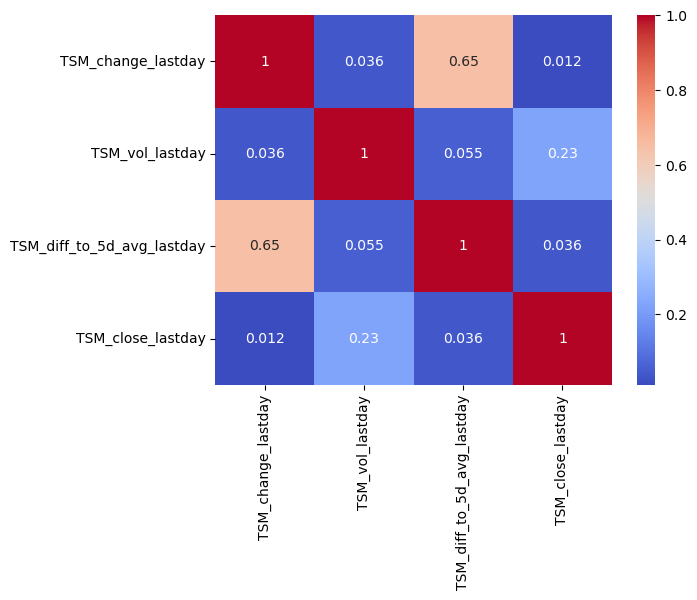

In [133]:
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## Train the Model with LinearRegression

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Evaluate the Result

In [80]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}')

MAE: 7.592, RMSE: 138.669, R²: 0.995


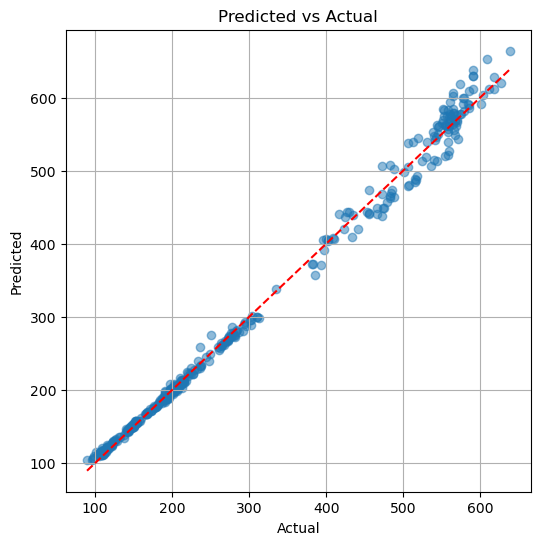

In [82]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

# Examine the Convergence

## Check for stationary of the spread (P value should < 0.05)

In [109]:
spread = y_pred - y_test # Measure the spread
result = adfuller(spread)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.553461803198233
p-value: 0.0001572348571860276


## Z-score of the spread

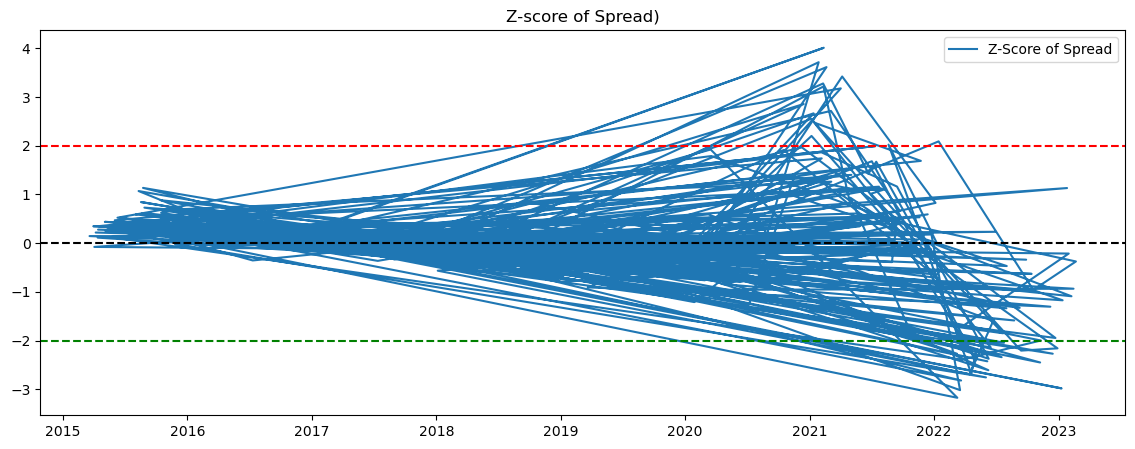

In [116]:
z_score = (spread - spread.mean()) / spread.std()

# Plot z-score to visually inspect convergence
plt.figure(figsize=(14,5))
plt.plot(z_score, label='Z-Score of Spread')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.title('Z-score of Spread)')
plt.legend()
plt.show()

[*********************100%***********************]  3 of 3 completed

ADF Statistic: -2.2815, p-value: 0.1780


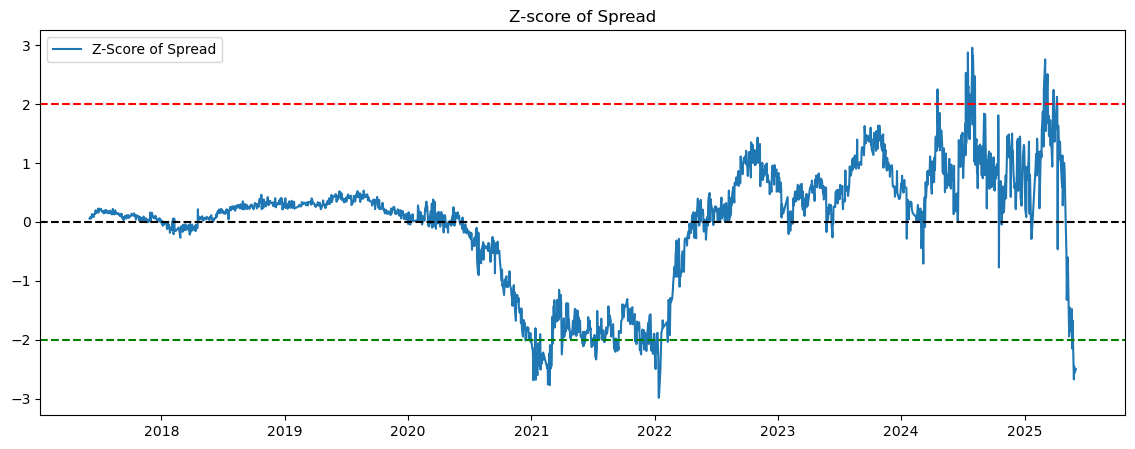

In [130]:
# from GPT
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Download data
data = yf.download(['TSM', '2330.TW', 'USDTWD=X'], period = '8y')['Close']
data = data.dropna()
# print(data.head())
stock1 = data['2330.TW'] * data['USDTWD=X']
stock2 = data['TSM']

# Regress stock1 on stock2 to get beta
X = add_constant(stock2)
model = OLS(stock1, X).fit()
beta = model.params['TSM']

# Calculate spread
spread = stock1 - beta * stock2

# ADF test for stationarity
adf_stat, pvalue, *_ = adfuller(spread)
print(f'ADF Statistic: {adf_stat:.4f}, p-value: {pvalue:.4f}')

# Calculate z-score
z_score = (spread - spread.mean()) / spread.std()

# Plot z-score to visually inspect convergence
plt.figure(figsize=(14,5))
plt.plot(z_score, label='Z-Score of Spread')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.title('Z-score of Spread')
plt.legend()
plt.show()

# Test run on seperate data

In [37]:
test_run_data = pd.DataFrame()
test_run_data = fetch_data_span(ticker = ['2330.TW', 'TSM', 'USDTWD=X'], start_time = "2023-02-25", end_time = "2025-02-25")

test_run_df = pd.DataFrame()
test_run_df['TSM_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_TSM')
test_run_df['TSM_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_TSM')
test_run_df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_TSM')
test_run_df['TSM_close_lastday'] = get_data_lastday(test_run_data, 'Close_TSM') * test_run_data['Close_USDTWD=X']
test_run_df['label'] = test_run_data['Close_2330.TW']
test_run_df_clean = test_run_df.dropna()

print(test_run_df_clean.head())

X_test_run = test_run_df_clean.drop(columns = ['label'])
y_test_run_pred = model.predict(X_test_run)
y_test_run = test_run_df_clean['label']

print("X_test_run:", len(X_test_run), "y_test_run_pred:", len(y_test_run_pred))


mae = mean_absolute_error(y_test_run, y_test_run_pred)
rmse = mean_squared_error(y_test_run, y_test_run_pred)
r2 = r2_score(y_test_run, y_test_run_pred)

print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}')

[*********************100%***********************]  3 of 3 completed

            TSM_change_lastday  TSM_vol_lastday  TSM_diff_to_5d_avg_lastday  \
Date                                                                          
2023-03-06            0.853658        -0.277040                    1.414406   
2023-03-07           -0.233896        -0.394165                    0.772710   
2023-03-08           -0.814897        -0.553012                   -0.273625   
2023-03-09            2.228460        -0.546136                    1.169669   
2023-03-10           -2.146876        -0.341870                   -0.680232   

            TSM_close_lastday       label  
Date                                       
2023-03-06        2638.480722  505.927277  
2023-03-07        2638.903515  508.840454  
2023-03-08        2630.351209  505.927277  
2023-03-09        2688.836325  506.898285  
2023-03-10        2638.740399  498.158661  
X_test_run: 515 y_test_run_pred: 515
MAE: 42.342, RMSE: 3571.852, R²: 0.927


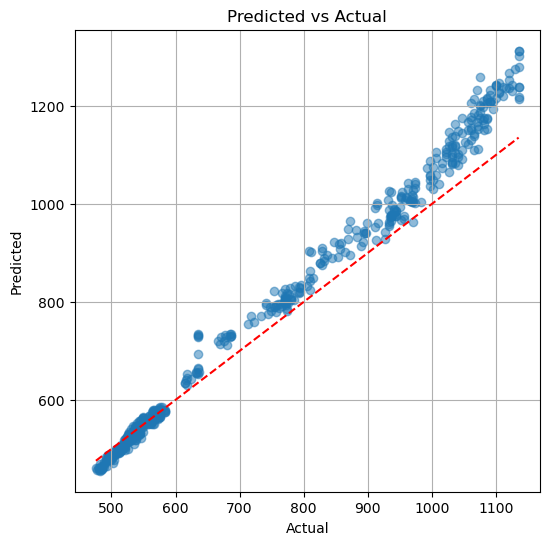

In [76]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_run, y_test_run_pred, alpha=0.5)
plt.plot([y_test_run.min(), y_test_run.max()], [y_test_run.min(), y_test_run.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

# Feature Importance

In [100]:
importances = model.feature_importances_
print(type(importances))
print(importances)

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

## Try finding Best-performing Hyper-perimeter

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'linear'],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

spread_mean = spread.mean()
spread_std = spread.std()

z_score = (spread - spread_mean) / spread_std# Potential Idea for features

instead of 2330, use different stocks/ indexs

more diff to avg(5d, w, m, y, 10y) data as features?

instead of indexes, use higher/ more direct related stocks

create test for real return
